<a href="https://colab.research.google.com/github/Trickshotblaster/nn-practices/blob/main/micrograd_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# micrograd exercises

1. watch the [micrograd video](https://www.youtube.com/watch?v=VMj-3S1tku0) on YouTube
2. come back and complete these exercises to level up :)

## section 1: derivatives

In [1]:
# here is a mathematical expression that takes 3 inputs and produces one output
from math import sin, cos

def f(a, b, c):
  return -a**3 + sin(3*b) - 1.0/c + b**2.5 - a**0.5

print(f(2, 3, 4))

6.336362190988558


In [2]:
# write the function df that returns the analytical gradient of f
# i.e. use your skills from calculus to take the derivative, then implement the formula
# if you do not calculus then feel free to ask wolframalpha, e.g.:
# https://www.wolframalpha.com/input?i=d%2Fda%28sin%283*a%29%29%29

def gradf(a, b, c):

  return [grada, gradb, gradc] # todo, return [df/da, df/db, df/dc]

# expected answer is the list of
ans = [-12.353553390593273, 10.25699027111255, 0.0625]
yours = gradf(2, 3, 4)
for dim in range(3):
  ok = 'OK' if abs(yours[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {yours[dim]}")


OK for dim 0: expected -12.353553390593273, yours returns -12.353553380251014
OK for dim 1: expected 10.25699027111255, yours returns 10.256990368162633
OK for dim 2: expected 0.0625, yours returns 0.0624999607623522


In [3]:
# now estimate the gradient numerically without any calculus, using
# the approximation we used in the video.
# you should not call the function df from the last cell

# -----------
h = 0.00000001
a = 2
b = 3
c = 4
normal = f(a, b, c)
grada = (f(a + h, b, c) - normal) / h
gradb = (f(a, b + h, c) - normal) / h
gradc = (f(a, b, c + h) - normal) / h
numerical_grad = [grada, gradb, gradc] # TODO
# -----------

for dim in range(3):
  ok = 'OK' if abs(numerical_grad[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {numerical_grad[dim]}")


OK for dim 0: expected -12.353553390593273, yours returns -12.353553380251014
OK for dim 1: expected 10.25699027111255, yours returns 10.256990368162633
OK for dim 2: expected 0.0625, yours returns 0.0624999607623522


In [4]:
# there is an alternative formula that provides a much better numerical
# approximation to the derivative of a function.
# learn about it here: https://en.wikipedia.org/wiki/Symmetric_derivative
# implement it. confirm that for the same step size h this version gives a
# better approximation.

# -----------
h = 0.0000001
syma = (f(a + h, b, c) - f(a - h, b, c)) / (2 * h)
symb = (f(a, b + h, c) - f(a, b - h, c)) / (2 * h)
symc = (f(a, b, c + h) - f(a, b, c - h)) / (2 * h)
numerical_grad2 = [syma, symb, symc] # TODO
# -----------

for dim in range(3):
  ok = 'OK' if abs(numerical_grad2[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {numerical_grad2[dim]}")


OK for dim 0: expected -12.353553390593273, yours returns -12.353553380251014
OK for dim 1: expected 10.25699027111255, yours returns 10.256990252699438
OK for dim 2: expected 0.0625, yours returns 0.06250000073038109


## section 2: support for softmax

In [5]:
import math

In [47]:
# Value class starter code, with many functions taken out
from math import exp, log

class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other): # exactly as in the video
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __radd__(self, other):
    return self + other

  def exp(self):
    out = Value(math.exp(self.data), (self, ), 'exp')
    def _backward():
      self.grad += out.grad # TODO
    out._backward = _backward

    return out

  def __pow__(self, other):
    out = Value(self.data ** other, (self, ), 'pow')
    def _backward():
      print("data", self.data)
      print("other", other)
      print("out grad", out.grad)
      self.grad += (self.data * (self.data ** other - 1))
    self._backward = _backward
    return out
  def __truediv__(self, other):
    return self * (other ** -1)

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    self._backward = _backward
    return out

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + -other

  def log(self):
    out = Value(math.log10(self.data), (self, ), 'log')
    def _backward():
      self.grad = (1 / (out.data * (math.log(10)))) * out.grad
    self._backward = _backward
    return out
  # ------
  # re-implement all the other functions needed for the exercises below
  # your code here
  # TODO
  # ------

  def backward(self): # exactly as in video
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [35]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
      if v not in nodes:
        nodes.add(v)
        for child in v._prev:
          edges.add((child, v))
          build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [48]:
# without referencing our code/video __too__ much, make this cell work
# you'll have to implement (in some cases re-implemented) a number of functions
# of the Value object, similar to what we've seen in the video.
# instead of the squared error loss this implements the negative log likelihood
# loss, which is very often used in classification.

# this is the softmax function
# https://en.wikipedia.org/wiki/Softmax_function
def softmax(logits):
  counts = [logit.exp() for logit in logits]
  print(counts)
  denominator = sum(counts)
  out = [c / denominator for c in counts]
  return out

# this is the negative log likelihood loss function, pervasive in classification
logits = [Value(0.0), Value(3.0), Value(-2.0), Value(1.0)]
probs = softmax(logits)
loss = -probs[3].log() # dim 3 acts as the label for this input example
loss.backward()
print(loss.data)

ans = [0.041772570515350445, 0.8390245074625319, 0.005653302662216329, -0.8864503806400986]
for dim in range(4):
  ok = 'OK' if abs(logits[dim].grad - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {logits[dim].grad}")


[Value(data=1.0), Value(data=20.085536923187668), Value(data=0.1353352832366127), Value(data=2.718281828459045)]
data 23.939154034883327
other -1
out grad 0.0
0.944814317280191
WRONG! for dim 0: expected 0.041772570515350445, yours returns 0.0
WRONG! for dim 1: expected 0.8390245074625319, yours returns 0.0
WRONG! for dim 2: expected 0.005653302662216329, yours returns 0.0
WRONG! for dim 3: expected -0.8864503806400986, yours returns 0.0


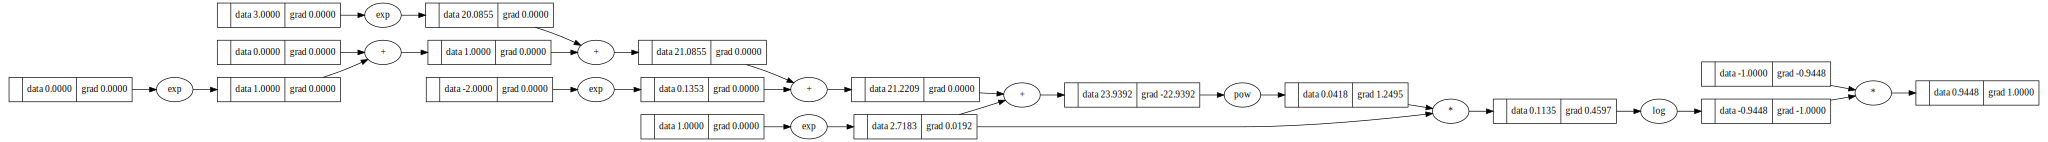

In [49]:
draw_dot(loss)

In [ ]:
# verify the gradient using the torch library
# torch should give you the exact same gradient
import torch
